# LQR on a Drake Diagram

The goal of this exercise is teach you a little more about using Drake to model and analyze systems.  Towards the end of [this Drake tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/%2Fdynamical_systems.ipynb), you learned a little about how to assemble a Diagram and then run a simple simulation.  In this problem, you'll make a Diagram, and then design an LQR controller for it.

To motivate this, let's say we already have a System which represents our mathematical model of some mechanical system. We'll use the double integrator here, but more commonly we could use the physics engine in Drake's [`MultibodyPlant`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html). These systems assume that our input is a perfect force/torque source. In practice, though, actuators like electric motors aren't perfect torque sources. In particular, they would struggle to produce the instantaneous changes in torque demanded from a bang-bang optimal controller.

We can capture this challenge by writing a second system that models the dynamics of the actuator. It's useful to write this as a different system, because if you write a really nice actuator model, then you can connect it to many different mechanical systems. This is how we do abstraction and write modular code for dynamical systems. Drake has a [growing library of models](https://drake.mit.edu/doxygen_cxx/group__systems.html) like this which can be assembled into complex Diagrams.

In [10]:
# Imports.
import numpy as np
import pydot
from IPython.display import display, SVG
from pydrake.all import LinearSystem, LinearQuadraticRegulator, DiagramBuilder

Let's build our diagram.  Note: we do it all in a single notebook cell because when you add a System to a Diagram, the Diagram takes ownership of that System; you cannot add one System to multiple Diagrams.  The components are as follows:

### 1) Plant model (a double integrator)

To keep things very simple, let's just use the double integrator as our "mechanical system". We've implemented that for you.

### 2) Actuator model (a low-pass filter)

The simplest model that we could imagine for the actuator is as a low-pass
filter: $$\tau\dot{x} = u - x, \quad y = x.$$ Let's use the time constant $\tau = 0.5$ seconds.

You can use `SymbolicVectorSystem`, `LinearSystem`, or write your own `LeafSystem`, but if you write your own `LeafSystem` you'll have to support Drake's automatic differentiation (`AutoDiffXd`) using the `TemplateSystem` decorator as described in the Drake [authoring leaf systems tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/%2Findex.ipynb).

### 3) Make the diagram

Finally, we want to connect the output of the actuator model to the input of the double integrator.  And to expose the input of the actuator model as an input to the diagram. 

Note: use `AddNamedSystem` in the `DiagramBuilder` and give yourself helpful names; it will make your debugging displays more useful below.

In [11]:
# 1) This system implements the Double Integrator model (q̈ = u, y = q).
double_integrator = LinearSystem(
    A=np.mat("0 1; 0 0"), B=np.mat("0; 1"), C=np.mat("1, 0"), D=[0]
)

# 2) TODO: Implement the actuator model.
actuator_model = LinearSystem(
    A=np.mat("-2"), B=np.mat("2"), C=np.mat("1"), D=[0]
)

# 3) TODO: Connect the double_integrator and the actuator_model together into a
# Diagram. The Diagram must have an input port for the actuator model input.
diagram = DiagramBuilder()
diagram.AddNamedSystem("double_integrator", double_integrator)
diagram.AddNamedSystem("actuator_model", actuator_model)
diagram.Connect(actuator_model.GetOutputPort("y0"), double_integrator.GetInputPort("u0"))
diagram.ExportInput(actuator_model.get_input_port(0))
diagram.ExportOutput(double_integrator.get_output_port(0))
diagram = diagram.Build()

The next cell provides a very useful visualization so that you can make sure that your diagram looks like you expect. Again make sure you use `AddNamedSystem` in the `DiagramBuilder` so that the boxes have legible names.

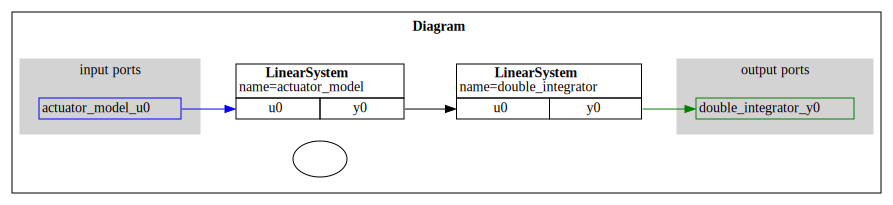

In [12]:
if diagram:
    display(
        SVG(
            pydot.graph_from_dot_data(diagram.GetGraphvizString())[
                0
            ].create_svg()
        )
    )

## Design an LQR controller

Finally we can call LQR.  Let's define the nominal state (which must be a fixed point) as 
- for the double integrator: $q_0 = 1.2, \dot{q}_0 = 0$,
- for the actuator model: $x_0 = 0$,
  
and the nominal input $u_0 = 0$. As always, we achieve this by setting the system `Context` and passing that to the `LinearQuadraticRegulator` method.

Note: The order of the states in the Diagram state might depend on how you assembled the Diagram. We use [`GetMyContextFromRoot`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html#ae7fa91d2b2102457ced3361207724e52) so that you can set the variables in the subsystem Contexts directly. These are pointers into the memory of the `diagram_context`, so changing the subsystem Context will change the diagram Context.

In [13]:
if diagram:
    diagram_context = diagram.CreateDefaultContext()
    double_integrator_context = double_integrator.GetMyContextFromRoot(
        diagram_context
    )
    actuator_model_context = actuator_model.GetMyContextFromRoot(
        diagram_context
    )
    # TODO: Set the context to be the desired fixed point (x₀, u₀). This
    # requires setting the state and fixing the input port.
    double_integrator_context.SetContinuousState([1.2, 0])
    actuator_model_context.SetContinuousState([0, 0])
    diagram.get_input_port(0).FixValue(diagram_context, 0)

    # We'll print the diagram context here so you can see the results of your
    # code.
    print(diagram_context)

IndexError: Operand vector size 2 does not match this drake::systems::BasicVector<double> size 1

Now we have everything we need to design the LQR controller. Thanks to the abstraction provided by the systems framework, designing a controller for the `Diagram` is no different, really, than designing a controller for a `LeafSystem`! This allows us to write principled algorithms for potentially very complex systems.

In [15]:
if diagram:
    # We'll cost terms in the objective simple:
    Q = np.eye(2)
    R = [1]

    # Now we can construct the LQR controller. A Diagram is a System, too... so
    # it all works!
    controller = LinearQuadraticRegulator(diagram, diagram_context, Q, R)

    print(f"Controller: u = u0 - K(x-x0), with K={-controller.D()}")

RuntimeError: InputPort::Eval(): required InputPort[0] (actuator_model_u0) of System ::_ (Diagram<double>) is not connected

## Autograding

The autograder will check your variables `double_integrator`, `actuator_model`, `diagram`, `diagram_context`, and `controller`; so don't change those variable names.

You can check your work by running the following cell:

In [14]:
from underactuated.exercises.lqr.test_drake_diagrams import TestDrakeDiagrams
from underactuated.exercises.grader import Grader

Grader.grade_output([TestDrakeDiagrams], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 2/4.

Score for test_actuator_model (underactuated.exercises.lqr.test_drake_diagrams.TestDrakeDiagrams) is 1/1.

Score for test_controller (underactuated.exercises.lqr.test_drake_diagrams.TestDrakeDiagrams) is 0/1.
- Test Failed: 'controller'


Score for test_diagram (underactuated.exercises.lqr.test_drake_diagrams.TestDrakeDiagrams) is 1/1.

Score for test_diagram_context (underactuated.exercises.lqr.test_drake_diagrams.TestDrakeDiagrams) is 0/1.
- Test Failed: you must fix a value for the diagram's input port



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9610d493-a15a-494f-b24e-0d139b1e7032' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>